In [70]:
######################### Basic LSTM with prediction for middle layer ####################
# In this notebook we build Sequence Models (LSTM, 1DCNN) for our sequence dataset.
# Lets import libraries.
import os
import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, LSTM, Conv1D,GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve,roc_auc_score
import matplotlib.pyplot as plt



In [6]:
# Lets load the Orginal datset and calculate the variable to noramlize the sequence.
store_25_Oct = pd.read_hdf("D:/CERN/data/singlepi_e100GeV_pu200_25Oct/singlepi_e100GeV_pu200.h5")
print('Total Number Of Records in 25-Oct-2019 data : {0} '.format(len(store_25_Oct)))

mean_E = np.mean(store_25_Oct['E'] )
std_E = np.std(store_25_Oct['E'] )

mean_eta = np.mean(store_25_Oct['eta'] )
std_eta = np.std(store_25_Oct['eta'] )

mean_phi = np.mean(store_25_Oct['phi'] )
std_phi = np.std(store_25_Oct['phi'] )

mean_x = np.mean(store_25_Oct['x'] )
std_x = np.std(store_25_Oct['x'] )

mean_y = np.mean(store_25_Oct['y'] )
std_y = np.std(store_25_Oct['y'] )

mean_z = np.mean(store_25_Oct['z'] )
std_z = np.std(store_25_Oct['z'] )

mean_nHits = np.mean(store_25_Oct['nHits'] )
std_nHits = np.std(store_25_Oct['nHits'] )





Total Number Of Records in 25-Oct-2019 data : 32274 


In [90]:
# Lets load the sequence dataset which has sequences of length 3 .
# Here we use identifier/prefix 'L3' to denote the length of the input sequence; ie L3 means sequence length is 3.
L3_immediate_layer_seq_store_25_Oct = pd.read_csv("D:/CERN/data/singlepi_e100GeV_pu200_25Oct/L3_immediate_layer_seq_store_25_Oct.csv")
L3_immediate_layer_seq_store_25_Oct.head(1)
len(L3_immediate_layer_seq_store_25_Oct)

L3_immediate_layer_seq_store_25_Oct_normalized = L3_immediate_layer_seq_store_25_Oct.copy()
L3_immediate_layer_seq_store_25_Oct_normalized.head(1)

L3_immediate_layer_seq_store_25_Oct_normalized['E'] = (L3_immediate_layer_seq_store_25_Oct_normalized.E - mean_E) / std_E
L3_immediate_layer_seq_store_25_Oct_normalized['eta'] = (L3_immediate_layer_seq_store_25_Oct_normalized.eta - mean_eta) / std_eta
L3_immediate_layer_seq_store_25_Oct_normalized['phi'] = (L3_immediate_layer_seq_store_25_Oct_normalized.phi - mean_phi) / std_phi
L3_immediate_layer_seq_store_25_Oct_normalized['x'] = (L3_immediate_layer_seq_store_25_Oct_normalized.x - mean_x) / std_x
L3_immediate_layer_seq_store_25_Oct_normalized['y'] = (L3_immediate_layer_seq_store_25_Oct_normalized.y - mean_y) / std_y
L3_immediate_layer_seq_store_25_Oct_normalized['z'] =  (L3_immediate_layer_seq_store_25_Oct_normalized.z - mean_z) / std_z
L3_immediate_layer_seq_store_25_Oct_normalized['nHits'] = (L3_immediate_layer_seq_store_25_Oct_normalized.nHits - mean_nHits) / std_nHits



total_sequences = L3_immediate_layer_seq_store_25_Oct_normalized.shape[0] //3
print('Total Number Of Sequences of length 3 in 25-Oct-2019 data : {0} '.format(total_sequences))

Total Number Of Sequences of length 3 in 25-Oct-2019 data : 30108 


In [91]:
L3_immediate_layer_seq_store_25_Oct_normalized.head(18)

,index_original,sequence_id,event,trackster,purity,layer,E,eta,phi,x,y,z,nHits,trckEn,trckEta,trckPhi,trckType
0,1,1_0_1,1.0,0.0,0.0,1.0,-0.175444,-0.148224,0.639593,-0.082362,0.633005,-0.858269,0.731336,57.759506,1.897144,0.196742,211.0
1,9,1_0_1,1.0,0.0,0.0,2.0,-0.200869,0.185687,0.620558,-0.324302,0.587929,-0.816664,-0.254089,57.759506,1.897144,0.196742,211.0
2,23,1_0_1,1.0,0.0,0.0,3.0,-0.262887,0.094513,0.684267,-0.247567,0.659124,-0.727444,-0.500445,57.759506,1.897144,0.196742,211.0
3,1,1_0_2,1.0,0.0,0.0,1.0,-0.175444,-0.148224,0.639593,-0.082362,0.633005,-0.858269,0.731336,57.759506,1.897144,0.196742,211.0
4,10,1_0_2,1.0,0.0,0.0,2.0,-0.196511,-0.073152,0.633177,-0.123334,0.622039,-0.816664,-0.254089,57.759506,1.897144,0.196742,211.0
5,23,1_0_2,1.0,0.0,0.0,3.0,-0.262887,0.094513,0.684267,-0.247567,0.659124,-0.727444,-0.500445,57.759506,1.897144,0.196742,211.0
6,2,1_0_3,1.0,0.0,0.0,1.0,-0.220151,-0.144319,0.396566,0.012880,0.397149,-0.858269,-0.500445,57.759506,1.897144,0.196742,211.0
7,11,1_0_3,1.0,0.0,0.0,2.0,-0.078176,-0.028019,0.426719,-0.075648,0.420755,-0.816664,0.238624,57.759506,1.897144,0.196742,211.0
8,24,1_0_3,1.0,0.0,1.0,3.0,0.545181,-0.299343,0.365483,0.210109,0.378739,-0.727444,2.948540,57.759506,1.897144,0.196742,211.0
9,3,1_0_4,1.0,0.0,0.0,1.0,-0.268674,-0.007692,1.003738,-0.420212,0.957504,-0.858269,-0.500445,57.759506,1.897144,0.196742,211.0


In [92]:
# The store_25_Oct has 3 purtity values (0 => Pileup,1 => Pileup + Pure ,2 => Pure ie NO Pileup),
# These values define the purtity of a layer cluster.
# For a Binary Classifier Problem, lets convert purity == 0 & 1 as Pileup label (0), and purity == 2 as Non-Pileup label (1)

L3_binary_labels_1D = L3_immediate_layer_seq_store_25_Oct_normalized.purity[1::3].copy()


In [93]:
L3_binary_labels_1D

1        0.0
4        0.0
7        0.0
10       0.0
13       0.0
        ... 
90310    2.0
90313    2.0
90316    2.0
90319    2.0
90322    2.0
Name: purity, Length: 30108, dtype: float64

In [94]:
L3_binary_labels_1D.value_counts()


0.0    22415
2.0     5814
1.0     1879
Name: purity, dtype: int64

In [95]:
L3_binary_labels_1D.where(L3_binary_labels_1D == 2.0 , 0.0 , inplace = True )


In [96]:
L3_binary_labels_1D.value_counts()

0.0    24294
2.0     5814
Name: purity, dtype: int64

In [97]:
L3_binary_labels_1D.where(L3_binary_labels_1D == 0.0 , 1.0 , inplace = True )


In [98]:
L3_binary_labels_1D.value_counts()

0.0    24294
1.0     5814
Name: purity, dtype: int64

In [99]:
L3_binary_labels_1D = L3_binary_labels_1D.values


In [100]:
L3_binary_labels_1D.shape
print('Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: {0} '.format(total_sequences))
print('Total Number Of Output Labels : {0} '.format(L3_binary_labels_1D.shape))

Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: 30108 
Total Number Of Output Labels : (30108,) 


In [131]:
# Categorical representation
L3_binary_labels_2D = L3_immediate_layer_seq_store_25_Oct_normalized.purity[1::3].copy()
L3_binary_labels_2D.value_counts()

L3_binary_labels_2D.where(L3_binary_labels_2D == 2.0 , 0.0 , inplace = True )

L3_binary_labels_2D.where(L3_binary_labels_2D == 0.0 , 1.0 , inplace = True )

L3_binary_labels_2D = L3_binary_labels_2D.values

L3_binary_labels_2D = to_categorical(L3_binary_labels_2D, num_classes = 2)

print('Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: {0} '.format(total_sequences))
print('Total Number Of Output Labels : {0} '.format(L3_binary_labels_2D.shape))

Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: 30108 
Total Number Of Output Labels : (30108, 2) 


In [132]:
# Lets create a numpy array of dimension (total_sequences, individual_seq_length,  number_of_features)
columns_for_model =  [ 'E', 'x', 'y', 'z','nHits']
L3_immediate_layer_sequences_array_25_Oct_normalized =  np.zeros((total_sequences, 3,  5))
L3_immediate_layer_sequences_array_25_Oct_normalized.shape


(30108, 3, 5)

In [133]:
L3_unique_seq_id = L3_immediate_layer_seq_store_25_Oct_normalized.sequence_id.unique()
print('Total L3 Unique Sequences: {0} '.format(len(L3_unique_seq_id)))


Total L3 Unique Sequences: 30108 


In [134]:
# Populate the Array
for i,seq_id in enumerate(L3_unique_seq_id):
    L3_immediate_layer_sequences_array_25_Oct_normalized[i] = L3_immediate_layer_seq_store_25_Oct_normalized[L3_immediate_layer_seq_store_25_Oct_normalized.sequence_id == seq_id][columns_for_model].values

In [135]:
# Split the Train and test data into 75-25
L3_X_train_binary, L3_X_test_binary, L3_y_train_binary, L3_y_test_binary = train_test_split(L3_immediate_layer_sequences_array_25_Oct_normalized , L3_binary_labels_2D, test_size=0.25, random_state=42)
print('Shape of L3_X_train_binary tensor:', L3_X_train_binary.shape)
print('Shape of L3_y_train_binary tensor:', L3_y_train_binary.shape)
print('Shape of L3_X_test_binary tensor:', L3_X_test_binary.shape)
print('Shape of L3_y_test_binary tensor:', L3_y_test_binary.shape)


Shape of L3_X_train_binary tensor: (22581, 3, 5)
Shape of L3_y_train_binary tensor: (22581, 2)
Shape of L3_X_test_binary tensor: (7527, 3, 5)
Shape of L3_y_test_binary tensor: (7527, 2)


In [136]:
# Lets Train a LSTM on L3  data
L3_model_LSTM_binary = Sequential()
L3_model_LSTM_binary.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 5)))
L3_model_LSTM_binary.add(Dense(2, activation='sigmoid'))
L3_model_LSTM_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(L3_model_LSTM_binary.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________
None


In [137]:
epochs = 200
batch_size = 32

L3_history_LSTM_binary = L3_model_LSTM_binary.fit(L3_X_train_binary, L3_y_train_binary, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 18064 samples, validate on 4517 samples
Epoch 1/200
18064/18064 [==============================] - 6s 306us/sample - loss: 0.3114 - accuracy: 0.8879 - val_loss: 0.2256 - val_accuracy: 0.9089
Epoch 2/200
18064/18064 [==============================] - 3s 153us/sample - loss: 0.2532 - accuracy: 0.9014 - val_loss: 0.2144 - val_accuracy: 0.9113
Epoch 3/200
18064/18064 [==============================] - 3s 158us/sample - loss: 0.2497 - accuracy: 0.9019 - val_loss: 0.2139 - val_accuracy: 0.9128
Epoch 4/200
18064/18064 [==============================] - 3s 154us/sample - loss: 0.2461 - accuracy: 0.9019 - val_loss: 0.2079 - val_accuracy: 0.9138
Epoch 5/200
18064/18064 [==============================] - 3s 154us/sample - loss: 0.2435 - accuracy: 0.9024 - val_loss: 0.2067 - val_accuracy: 0.9117
Epoch 6/200
18064/18064 [==============================] - 3s 154us/sample - loss: 0.2422 - accuracy: 0.9038 - val_loss: 0.2056 - val_accuracy: 0.9129
Epoch 7/200
18064/18064 [====================

In [138]:
# L3 LSTM Train Accuracy 
L3_LSTM_train_accr_binary = L3_model_LSTM_binary.evaluate(L3_X_train_binary,L3_y_train_binary)
print('L3 LSTM Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L3_LSTM_train_accr_binary[0],L3_LSTM_train_accr_binary[1]))
#loss: 0.203 - accuracy: 0.916



22581/1 [=] - 1s 46us/sample - loss: 0.2374 - accuracy: 0.9159
L3 LSTM Train set
  Loss: 0.203
  Accuracy: 0.916


In [139]:
# L3 LSTM Test Accuracy 
L3_LSTM_test_accr_binary = L3_model_LSTM_binary.evaluate(L3_X_test_binary,L3_y_test_binary)
print('L3 LSTM Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L3_LSTM_test_accr_binary[0],L3_LSTM_test_accr_binary[1]))
#Loss: 0.201  Accuracy: 0.919

7527/1 [=] - 0s 48us/sample - loss: 0.2505 - accuracy: 0.9186
L3 LSTM Test set
  Loss: 0.201
  Accuracy: 0.919


In [140]:
# L3 LSTM Confution Matrix 

L3_LSTM_Y_pred_test_binary = L3_model_LSTM_binary.predict(L3_X_test_binary)

print('L3_LSTM_Y_pred_test_binary.shape : {}'.format(L3_LSTM_Y_pred_test_binary.shape))
print('L3_LSTM_Y_pred_test_binary[-1]: {}'.format(L3_LSTM_Y_pred_test_binary[-1]))


L3_LSTM_Y_pred_test_binary_1D = np.argmax(L3_LSTM_Y_pred_test_binary,axis = 1)
print('L3_LSTM_Y_pred_test_binary_1D.shape : {}'.format(L3_LSTM_Y_pred_test_binary_1D.shape))
print('L3_LSTM_Y_pred_test_binary_1D[-1]: {}'.format(L3_LSTM_Y_pred_test_binary_1D[-1]))

L3_LSTM_y_test_binary_1D = np.argmax(L3_y_test_binary,axis = 1)
print('L3_LSTM_y_test_binary_1D.shape : {}'.format(L3_LSTM_y_test_binary_1D.shape))

from sklearn.metrics import  confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(L3_LSTM_y_test_binary_1D, L3_LSTM_Y_pred_test_binary_1D))

L3_LSTM_Y_pred_test_binary.shape : (7527, 2)
L3_LSTM_Y_pred_test_binary[-1]: [0.91146845 0.08697259]
L3_LSTM_Y_pred_test_binary_1D.shape : (7527,)
L3_LSTM_Y_pred_test_binary_1D[-1]: 0
L3_LSTM_y_test_binary_1D.shape : (7527,)
Confusion Matrix
[[5894  193]
 [ 420 1020]]


In [141]:
# L3 LSTM f1_score

from sklearn.metrics import f1_score
L3_LSTM_f1_score = f1_score(L3_LSTM_y_test_binary_1D,L3_LSTM_Y_pred_test_binary_1D)
print('L3 LSTM F1 Score  : {}'.format(L3_LSTM_f1_score))

L3 LSTM F1 Score  : 0.7689408217112702


In [142]:
# Generic Function For plotting ROC Curve
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,"b--",linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel("False Positive Rate", fontsize=16)
    plt.ylabel("True Positive Rate", fontsize=16)


L3_LSTM_Y_pred_test_score_class1.shape : (7527,)
L3 LSTM ROC_AUC  : 0.955634845663801


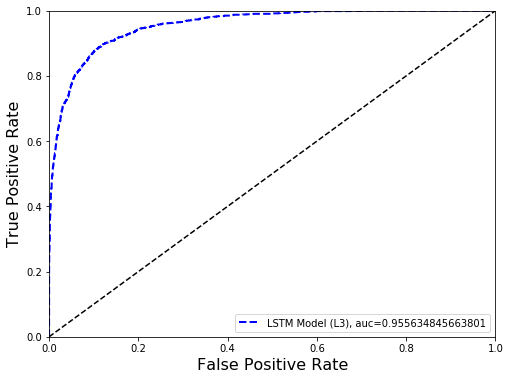

In [143]:
# ROC Curve For L3 LSTM
# For ROC curve pass the probability estimates of the positive class ie class =1

L3_LSTM_Y_pred_test_score_class1 = L3_LSTM_Y_pred_test_binary[:,1]
print('L3_LSTM_Y_pred_test_score_class1.shape : {}'.format(L3_LSTM_Y_pred_test_score_class1.shape))

L3_LSTM_fpr,L3_LSTM_tpr,L3_LSTM_thresholds = roc_curve(L3_LSTM_y_test_binary_1D,L3_LSTM_Y_pred_test_score_class1)
L3_LSTM_roc_auc = roc_auc_score(L3_LSTM_y_test_binary_1D,L3_LSTM_Y_pred_test_score_class1)
print('L3 LSTM ROC_AUC  : {}'.format(L3_LSTM_roc_auc))
plt.figure(figsize=(8, 6))
plot_roc_curve(L3_LSTM_fpr, L3_LSTM_tpr,label="LSTM Model (L3), auc="+str(L3_LSTM_roc_auc) )
plt.legend(loc=0)
plt.show()

In [144]:
################################################ 1D CNN (L3 Data) ######################################################################

# Lets Train a 1DCNN on L3 data
L3_model_1DCNN_binary = Sequential()
L3_model_1DCNN_binary.add(Conv1D(32, kernel_size= 3, activation='relu',input_shape=(3,5)))
L3_model_1DCNN_binary.add(GlobalAveragePooling1D())
L3_model_1DCNN_binary.add(Dense(2, activation='sigmoid'))
L3_model_1DCNN_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(L3_model_1DCNN_binary.summary())


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 1, 32)             512       
_________________________________________________________________
global_average_pooling1d_3 ( (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 66        
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________
None


In [145]:
epochs = 200
batch_size = 32

L3_history_1DCNN_binary = L3_model_1DCNN_binary.fit(L3_X_train_binary, L3_y_train_binary, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 18064 samples, validate on 4517 samples
Epoch 1/200
18064/18064 [==============================] - 2s 112us/sample - loss: 0.2882 - accuracy: 0.8934 - val_loss: 0.2173 - val_accuracy: 0.9114
Epoch 2/200
18064/18064 [==============================] - 1s 71us/sample - loss: 0.2194 - accuracy: 0.9123 - val_loss: 0.2071 - val_accuracy: 0.9143
Epoch 3/200
18064/18064 [==============================] - 1s 70us/sample - loss: 0.2109 - accuracy: 0.9149 - val_loss: 0.2018 - val_accuracy: 0.9184
Epoch 4/200
18064/18064 [==============================] - 1s 70us/sample - loss: 0.2072 - accuracy: 0.9154 - val_loss: 0.2016 - val_accuracy: 0.9171
Epoch 5/200
18064/18064 [==============================] - 1s 68us/sample - loss: 0.2052 - accuracy: 0.9156 - val_loss: 0.2001 - val_accuracy: 0.9168
Epoch 6/200
18064/18064 [==============================] - 1s 69us/sample - loss: 0.2042 - accuracy: 0.9167 - val_loss: 0.2008 - val_accuracy: 0.9166
Epoch 7/200
18064/18064 [=========================

In [146]:
# L3 1DCNN Train Accuracy 
L3_1DCNN_train_accr_binary = L3_model_1DCNN_binary.evaluate(L3_X_train_binary,L3_y_train_binary)
print('L3 1DCNN Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L3_1DCNN_train_accr_binary[0],L3_1DCNN_train_accr_binary[1]))
#loss: 0.190 - accuracy: 0.923


22581/1 [=] - 1s 25us/sample - loss: 0.2191 - accuracy: 0.9230
L3 1DCNN Train set
  Loss: 0.190
  Accuracy: 0.923


In [147]:
# L3 1DCNN Test Accuracy 
L3_1DCNN_test_accr_binary = L3_model_1DCNN_binary.evaluate(L3_X_test_binary,L3_y_test_binary)
print('L3 1DCNN Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L3_1DCNN_test_accr_binary[0],L3_1DCNN_test_accr_binary[1]))
#Loss: 0.191  Accuracy: 0.923


7527/1 [=] - 0s 25us/sample - loss: 0.2491 - accuracy: 0.9225
L3 1DCNN Test set
  Loss: 0.191
  Accuracy: 0.923


In [148]:
# L3 1DCNN Confution Matrix 

L3_1DCNN_Y_pred_test_binary = L3_model_1DCNN_binary.predict(L3_X_test_binary)

print('L3_1DCNN_Y_pred_test_binary.shape : {}'.format(L3_1DCNN_Y_pred_test_binary.shape))
print('L3_1DCNN_Y_pred_test_binary[-1]: {}'.format(L3_1DCNN_Y_pred_test_binary[-1]))


L3_1DCNN_Y_pred_test_binary_1D = np.argmax(L3_1DCNN_Y_pred_test_binary,axis = 1)
print('L3_1DCNN_Y_pred_test_binary_1D.shape : {}'.format(L3_1DCNN_Y_pred_test_binary_1D.shape))
print('L3_1DCNN_Y_pred_test_binary_1D[-1]: {}'.format(L3_1DCNN_Y_pred_test_binary_1D[-1]))

L3_1DCNN_y_test_binary_1D = np.argmax(L3_y_test_binary,axis = 1)
print('L3_1DCNN_y_test_binary_1D.shape : {}'.format(L3_1DCNN_y_test_binary_1D.shape))

from sklearn.metrics import  confusion_matrix

print('Confusion Matrix For L3 1DCNN')
print(confusion_matrix(L3_1DCNN_y_test_binary_1D, L3_1DCNN_Y_pred_test_binary_1D))


L3_1DCNN_Y_pred_test_binary.shape : (7527, 2)
L3_1DCNN_Y_pred_test_binary[-1]: [0.9802485  0.01607617]
L3_1DCNN_Y_pred_test_binary_1D.shape : (7527,)
L3_1DCNN_Y_pred_test_binary_1D[-1]: 0
L3_1DCNN_y_test_binary_1D.shape : (7527,)
Confusion Matrix For L3 1DCNN
[[5874  213]
 [ 371 1069]]


In [149]:
# L3 1DCNN f1_score

from sklearn.metrics import f1_score
L3_1DCNN_f1_score = f1_score(L3_1DCNN_y_test_binary_1D,L3_1DCNN_Y_pred_test_binary_1D)
print('L3 1DCNN F1 Score  : {}'.format(L3_1DCNN_f1_score))

L3 1DCNN F1 Score  : 0.7854518736223365


L3_1DCNN_Y_pred_test_score_class1.shape : (7527,)
L3 1DCNN ROC_AUC  : 0.9601438858770056


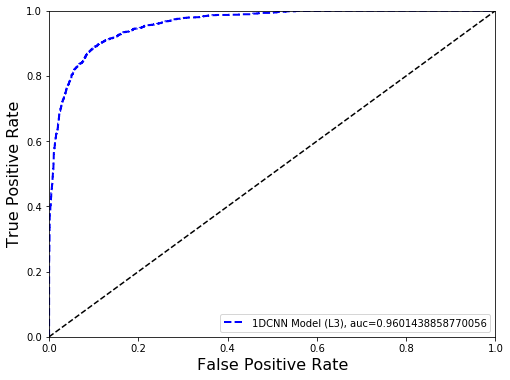

In [150]:
# ROC Curve For L3 1DCNN
# For ROC curve pass the probability estimates of the positive class ie class =1

L3_1DCNN_Y_pred_test_score_class1 = L3_1DCNN_Y_pred_test_binary[:,1]
print('L3_1DCNN_Y_pred_test_score_class1.shape : {}'.format(L3_1DCNN_Y_pred_test_score_class1.shape))

L3_1DCNN_fpr,L3_1DCNN_tpr,L3_1DCNN_thresholds = roc_curve(L3_1DCNN_y_test_binary_1D,L3_1DCNN_Y_pred_test_score_class1)
L3_1DCNN_roc_auc = roc_auc_score(L3_1DCNN_y_test_binary_1D,L3_1DCNN_Y_pred_test_score_class1)
print('L3 1DCNN ROC_AUC  : {}'.format(L3_1DCNN_roc_auc))
plt.figure(figsize=(8, 6))
plot_roc_curve(L3_1DCNN_fpr, L3_1DCNN_tpr,label="1DCNN Model (L3), auc="+str(L3_1DCNN_roc_auc) )
plt.legend(loc=0)
plt.show()

# Sequence Models for Sequnece length 5          


In [152]:
# Lets load the sequence dataset which has sequences of length 5 .
# Here we use identifier/prefix 'L5' to denote the length of the input sequence; ie L5 means sequence length is 5.
L5_immediate_layer_seq_store_25_Oct = pd.read_csv("D:/CERN/data/singlepi_e100GeV_pu200_25Oct/L5_immediate_layer_seq_store_25_Oct.csv")
L5_immediate_layer_seq_store_25_Oct.head(1)
len(L5_immediate_layer_seq_store_25_Oct)

L5_immediate_layer_seq_store_25_Oct_normalized = L5_immediate_layer_seq_store_25_Oct.copy()
L5_immediate_layer_seq_store_25_Oct_normalized.head(1)

L5_immediate_layer_seq_store_25_Oct_normalized['E'] = (L5_immediate_layer_seq_store_25_Oct_normalized.E - mean_E) / std_E
L5_immediate_layer_seq_store_25_Oct_normalized['eta'] = (L5_immediate_layer_seq_store_25_Oct_normalized.eta - mean_eta) / std_eta
L5_immediate_layer_seq_store_25_Oct_normalized['phi'] = (L5_immediate_layer_seq_store_25_Oct_normalized.phi - mean_phi) / std_phi
L5_immediate_layer_seq_store_25_Oct_normalized['x'] = (L5_immediate_layer_seq_store_25_Oct_normalized.x - mean_x) / std_x
L5_immediate_layer_seq_store_25_Oct_normalized['y'] = (L5_immediate_layer_seq_store_25_Oct_normalized.y - mean_y) / std_y
L5_immediate_layer_seq_store_25_Oct_normalized['z'] =  (L5_immediate_layer_seq_store_25_Oct_normalized.z - mean_z) / std_z
L5_immediate_layer_seq_store_25_Oct_normalized['nHits'] = (L5_immediate_layer_seq_store_25_Oct_normalized.nHits - mean_nHits) / std_nHits



total_sequences_L5 = L5_immediate_layer_seq_store_25_Oct_normalized.shape[0] // 5 
print('Total Number Of Sequences of length 5 in 25-Oct-2019 data : {0} '.format(total_sequences_L5))

Total Number Of Sequences of length 5 in 25-Oct-2019 data : 28413 


In [153]:
L5_binary_labels_1D = L5_immediate_layer_seq_store_25_Oct_normalized.purity[2::5].copy()

In [154]:
L5_binary_labels_1D.value_counts()

0.0    21856
2.0     4820
1.0     1737
Name: purity, dtype: int64

In [155]:
L5_binary_labels_1D.where(L5_binary_labels_1D == 2.0 , 0.0 , inplace = True )
L5_binary_labels_1D.value_counts()

0.0    23593
2.0     4820
Name: purity, dtype: int64

In [156]:
L5_binary_labels_1D.where(L5_binary_labels_1D == 0.0 , 1.0 , inplace = True )
L5_binary_labels_1D.value_counts()

0.0    23593
1.0     4820
Name: purity, dtype: int64

In [157]:
L5_binary_labels_1D = L5_binary_labels_1D.values
L5_binary_labels_1D.shape
print('Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: {0} '.format(total_sequences_L5))
print('Total Number Of Output Labels : {0} '.format(L5_binary_labels_1D.shape))

Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: 28413 
Total Number Of Output Labels : (28413,) 


In [158]:
# Categorical representation
L5_binary_labels_2D = L5_immediate_layer_seq_store_25_Oct_normalized.purity[2::5].copy()
L5_binary_labels_2D.value_counts()

L5_binary_labels_2D.where(L5_binary_labels_2D == 2.0 , 0.0 , inplace = True )

L5_binary_labels_2D.where(L5_binary_labels_2D == 0.0 , 1.0 , inplace = True )

L5_binary_labels_2D = L5_binary_labels_2D.values

L5_binary_labels_2D = to_categorical(L5_binary_labels_2D, num_classes = 2)

print('Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: {0} '.format(total_sequences_L5))
print('Total Number Of Output Labels : {0} '.format(L5_binary_labels_2D.shape))

Total Number Of Output Labels should be equal to Total Number Of Sequnces, which are: 28413 
Total Number Of Output Labels : (28413, 2) 


In [159]:
# Lets create a numpy array of dimension (total_sequences, individual_seq_length,  number_of_features)
columns_for_model =  [ 'E', 'x', 'y', 'z','nHits']
L5_immediate_layer_sequences_array_25_Oct_normalized =  np.zeros((total_sequences_L5, 5,  5))
L5_immediate_layer_sequences_array_25_Oct_normalized.shape

L5_unique_seq_id = L5_immediate_layer_seq_store_25_Oct_normalized.sequence_id.unique()
print('Total L5 Unique Sequences: {0} '.format(len(L5_unique_seq_id)))

Total L5 Unique Sequences: 28413 


In [160]:
# Populate the Array
for i,seq_id in enumerate(L5_unique_seq_id):
    L5_immediate_layer_sequences_array_25_Oct_normalized[i] = L5_immediate_layer_seq_store_25_Oct_normalized[L5_immediate_layer_seq_store_25_Oct_normalized.sequence_id == seq_id][columns_for_model].values
    

In [161]:
# Split the Train and test data into 75-25
L5_X_train_binary, L5_X_test_binary, L5_y_train_binary, L5_y_test_binary = train_test_split(L5_immediate_layer_sequences_array_25_Oct_normalized , L5_binary_labels_2D, test_size=0.25, random_state=42)
print('Shape of L5_X_train_binary tensor:', L5_X_train_binary.shape)
print('Shape of L5_y_train_binary tensor:', L5_y_train_binary.shape)
print('Shape of L5_X_test_binary tensor:', L5_X_test_binary.shape)
print('Shape of L5_y_test_binary tensor:', L5_y_test_binary.shape)

Shape of L5_X_train_binary tensor: (21309, 5, 5)
Shape of L5_y_train_binary tensor: (21309, 2)
Shape of L5_X_test_binary tensor: (7104, 5, 5)
Shape of L5_y_test_binary tensor: (7104, 2)


In [162]:
# Lets Train a LSTM on L5  data
L5_model_LSTM_binary = Sequential()
L5_model_LSTM_binary.add(LSTM(32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, 5)))
L5_model_LSTM_binary.add(Dense(2, activation='sigmoid'))
L5_model_LSTM_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(L5_model_LSTM_binary.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                4864      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 66        
Total params: 4,930
Trainable params: 4,930
Non-trainable params: 0
_________________________________________________________________
None


In [163]:
epochs = 200
batch_size = 32

L5_history_LSTM_binary = L5_model_LSTM_binary.fit(L5_X_train_binary, L5_y_train_binary, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 17047 samples, validate on 4262 samples
Epoch 1/200
17047/17047 [==============================] - 6s 356us/sample - loss: 0.2841 - accuracy: 0.8954 - val_loss: 0.2108 - val_accuracy: 0.9168
Epoch 2/200
17047/17047 [==============================] - 3s 201us/sample - loss: 0.2377 - accuracy: 0.9072 - val_loss: 0.2050 - val_accuracy: 0.9187
Epoch 3/200
17047/17047 [==============================] - 3s 204us/sample - loss: 0.2317 - accuracy: 0.9074 - val_loss: 0.2022 - val_accuracy: 0.9195
Epoch 4/200
17047/17047 [==============================] - 4s 207us/sample - loss: 0.2251 - accuracy: 0.9105 - val_loss: 0.2025 - val_accuracy: 0.9178
Epoch 5/200
17047/17047 [==============================] - 3s 200us/sample - loss: 0.2268 - accuracy: 0.9097 - val_loss: 0.1993 - val_accuracy: 0.9206
Epoch 6/200
17047/17047 [==============================] - 4s 209us/sample - loss: 0.2282 - accuracy: 0.9093 - val_loss: 0.1986 - val_accuracy: 0.9192
Epoch 7/200
17047/17047 [====================

In [164]:
# L5 LSTM Train Accuracy 
L5_LSTM_train_accr_binary = L5_model_LSTM_binary.evaluate(L5_X_train_binary,L5_y_train_binary)
print('L5 LSTM Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L5_LSTM_train_accr_binary[0],L5_LSTM_train_accr_binary[1]))
#loss: 0.200 - accuracy: 0.919

21309/1 [=] - 1s 55us/sample - loss: 0.2176 - accuracy: 0.9191
L5 LSTM Train set
  Loss: 0.200
  Accuracy: 0.919


In [165]:
# L5 LSTM Test Accuracy 
L5_LSTM_test_accr_binary = L5_model_LSTM_binary.evaluate(L5_X_test_binary,L5_y_test_binary)
print('L5 LSTM Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L5_LSTM_test_accr_binary[0],L5_LSTM_test_accr_binary[1]))
#Loss: 0.202  Accuracy: 0.921

7104/1 [=] - 1s 100us/sample - loss: 0.2365 - accuracy: 0.9207
L5 LSTM Test set
  Loss: 0.202
  Accuracy: 0.921


In [166]:
# L5 LSTM Confution Matrix 

L5_LSTM_Y_pred_test_binary = L5_model_LSTM_binary.predict(L5_X_test_binary)

print('L5_LSTM_Y_pred_test_binary.shape : {}'.format(L5_LSTM_Y_pred_test_binary.shape))
print('L5_LSTM_Y_pred_test_binary[-1]: {}'.format(L5_LSTM_Y_pred_test_binary[-1]))


L5_LSTM_Y_pred_test_binary_1D = np.argmax(L5_LSTM_Y_pred_test_binary,axis = 1)
print('L5_LSTM_Y_pred_test_binary_1D.shape : {}'.format(L5_LSTM_Y_pred_test_binary_1D.shape))
print('L5_LSTM_Y_pred_test_binary_1D[-1]: {}'.format(L5_LSTM_Y_pred_test_binary_1D[-1]))

L5_LSTM_y_test_binary_1D = np.argmax(L5_y_test_binary,axis = 1)
print('L5_LSTM_y_test_binary_1D.shape : {}'.format(L5_LSTM_y_test_binary_1D.shape))

from sklearn.metrics import  confusion_matrix

print('L5 Confusion Matrix LSTM')
print(confusion_matrix(L5_LSTM_y_test_binary_1D, L5_LSTM_Y_pred_test_binary_1D))


L5_LSTM_Y_pred_test_binary.shape : (7104, 2)
L5_LSTM_Y_pred_test_binary[-1]: [0.99858713 0.00147268]
L5_LSTM_Y_pred_test_binary_1D.shape : (7104,)
L5_LSTM_Y_pred_test_binary_1D[-1]: 0
L5_LSTM_y_test_binary_1D.shape : (7104,)
L5 Confusion Matrix LSTM
[[5650  269]
 [ 292  893]]


In [167]:
# L5 LSTM f1_score

from sklearn.metrics import f1_score
L5_LSTM_f1_score = f1_score(L5_LSTM_y_test_binary_1D,L5_LSTM_Y_pred_test_binary_1D)
print('L5 LSTM F1 Score  : {}'.format(L5_LSTM_f1_score))

L5 LSTM F1 Score  : 0.7609714529186193


L5_LSTM_Y_pred_test_score_class1.shape : (7104,)
L5 LSTM ROC_AUC  : 0.9493548274419146


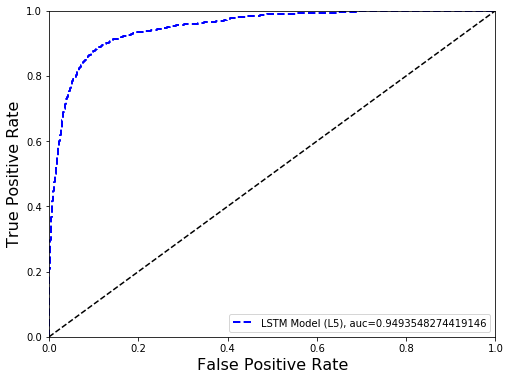

In [168]:
# ROC Curve For L5 LSTM
# For ROC curve pass the probability estimates of the positive class ie class =1

L5_LSTM_Y_pred_test_score_class1 = L5_LSTM_Y_pred_test_binary[:,1]
print('L5_LSTM_Y_pred_test_score_class1.shape : {}'.format(L5_LSTM_Y_pred_test_score_class1.shape))

L5_LSTM_fpr,L5_LSTM_tpr,L5_LSTM_thresholds = roc_curve(L5_LSTM_y_test_binary_1D,L5_LSTM_Y_pred_test_score_class1)
L5_LSTM_roc_auc = roc_auc_score(L5_LSTM_y_test_binary_1D,L5_LSTM_Y_pred_test_score_class1)
print('L5 LSTM ROC_AUC  : {}'.format(L5_LSTM_roc_auc))
plt.figure(figsize=(8, 6))
plot_roc_curve(L5_LSTM_fpr, L5_LSTM_tpr,label="LSTM Model (L5), auc="+str(L5_LSTM_roc_auc) )
plt.legend(loc=0)
plt.show()

In [169]:
################################################ 1D CNN (L5 Data) ######################################################################

# Lets Train a 1DCNN on L5 data
L5_model_1DCNN_binary = Sequential()
L5_model_1DCNN_binary.add(Conv1D(32, kernel_size= 3, activation='relu',input_shape=(5,5)))
L5_model_1DCNN_binary.add(GlobalAveragePooling1D())
L5_model_1DCNN_binary.add(Dense(2, activation='sigmoid'))
L5_model_1DCNN_binary.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(L5_model_1DCNN_binary.summary())

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 3, 32)             512       
_________________________________________________________________
global_average_pooling1d_4 ( (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 66        
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________
None


In [170]:
epochs = 200
batch_size = 32

L5_history_1DCNN_binary = L5_model_1DCNN_binary.fit(L5_X_train_binary, L5_y_train_binary, epochs=epochs, batch_size=batch_size,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Train on 17047 samples, validate on 4262 samples
Epoch 1/200
17047/17047 [==============================] - 2s 114us/sample - loss: 0.2661 - accuracy: 0.9043 - val_loss: 0.2113 - val_accuracy: 0.9176
Epoch 2/200
17047/17047 [==============================] - 1s 72us/sample - loss: 0.2088 - accuracy: 0.9156 - val_loss: 0.1984 - val_accuracy: 0.9213
Epoch 3/200
17047/17047 [==============================] - 1s 71us/sample - loss: 0.1997 - accuracy: 0.9181 - val_loss: 0.1940 - val_accuracy: 0.9243
Epoch 4/200
17047/17047 [==============================] - 1s 74us/sample - loss: 0.1959 - accuracy: 0.9192 - val_loss: 0.1910 - val_accuracy: 0.9239
Epoch 5/200
17047/17047 [==============================] - 1s 73us/sample - loss: 0.1944 - accuracy: 0.9198 - val_loss: 0.1903 - val_accuracy: 0.9243
Epoch 6/200
17047/17047 [==============================] - 1s 75us/sample - loss: 0.1927 - accuracy: 0.9209 - val_loss: 0.1897 - val_accuracy: 0.9249
Epoch 7/200
17047/17047 [=========================

In [171]:
# L5 1DCNN Train Accuracy 
L5_1DCNN_train_accr_binary = L5_model_1DCNN_binary.evaluate(L5_X_train_binary,L5_y_train_binary)
print('L5 1DCNN Train set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L5_1DCNN_train_accr_binary[0],L5_1DCNN_train_accr_binary[1]))
#loss: 0.185 - accuracy: 0.925

21309/1 [=] - 1s 25us/sample - loss: 0.2200 - accuracy: 0.9249
L5 1DCNN Train set
  Loss: 0.185
  Accuracy: 0.925


In [172]:
# L5 1DCNN Test Accuracy 
L5_1DCNN_test_accr_binary = L5_model_1DCNN_binary.evaluate(L5_X_test_binary,L5_y_test_binary)
print('L5 1DCNN Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(L5_1DCNN_test_accr_binary[0],L5_1DCNN_test_accr_binary[1]))
#Loss: 0.190  Accuracy: 0.92


7104/1 [=] - 0s 46us/sample - loss: 0.2235 - accuracy: 0.9254
L5 1DCNN Test set
  Loss: 0.190
  Accuracy: 0.925


In [174]:
# L5 1DCNN Confution Matrix 

L5_1DCNN_Y_pred_test_binary = L5_model_1DCNN_binary.predict(L5_X_test_binary)

print('L5_1DCNN_Y_pred_test_binary.shape : {}'.format(L5_1DCNN_Y_pred_test_binary.shape))
print('L5_1DCNN_Y_pred_test_binary[-1]: {}'.format(L5_1DCNN_Y_pred_test_binary[-1]))


L5_1DCNN_Y_pred_test_binary_1D = np.argmax(L5_1DCNN_Y_pred_test_binary,axis = 1)
print('L5_1DCNN_Y_pred_test_binary_1D.shape : {}'.format(L5_1DCNN_Y_pred_test_binary_1D.shape))
print('L5_1DCNN_Y_pred_test_binary_1D[-1]: {}'.format(L5_1DCNN_Y_pred_test_binary_1D[-1]))

L5_1DCNN_y_test_binary_1D = np.argmax(L5_y_test_binary,axis = 1)
print('L5_1DCNN_y_test_binary_1D.shape : {}'.format(L5_1DCNN_y_test_binary_1D.shape))

from sklearn.metrics import  confusion_matrix

print('Confusion Matrix For L5 1DCNN')
print(confusion_matrix(L5_1DCNN_y_test_binary_1D, L5_1DCNN_Y_pred_test_binary_1D))

L5_1DCNN_Y_pred_test_binary.shape : (7104, 2)
L5_1DCNN_Y_pred_test_binary[-1]: [0.9990722  0.00105056]
L5_1DCNN_Y_pred_test_binary_1D.shape : (7104,)
L5_1DCNN_Y_pred_test_binary_1D[-1]: 0
L5_1DCNN_y_test_binary_1D.shape : (7104,)
Confusion Matrix For L5 1DCNN
[[5670  249]
 [ 275  910]]


In [175]:
# L5 1DCNN f1_score

from sklearn.metrics import f1_score
L5_1DCNN_f1_score = f1_score(L5_1DCNN_y_test_binary_1D,L5_1DCNN_Y_pred_test_binary_1D)
print('L5 1DCNN F1 Score  : {}'.format(L5_1DCNN_f1_score))


L5 1DCNN F1 Score  : 0.7764505119453925


L5_1DCNN_Y_pred_test_score_class1.shape : (7104,)
L5 1DCNN ROC_AUC  : 0.9560879895466434


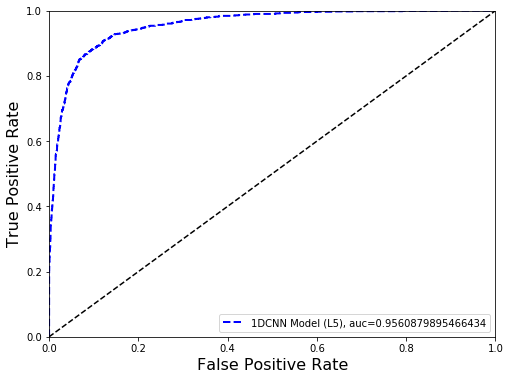

In [176]:
# ROC Curve For L5 1DCNN
# For ROC curve pass the probability estimates of the positive class ie class =1

L5_1DCNN_Y_pred_test_score_class1 = L5_1DCNN_Y_pred_test_binary[:,1]
print('L5_1DCNN_Y_pred_test_score_class1.shape : {}'.format(L5_1DCNN_Y_pred_test_score_class1.shape))

L5_1DCNN_fpr,L5_1DCNN_tpr,L5_1DCNN_thresholds = roc_curve(L5_1DCNN_y_test_binary_1D,L5_1DCNN_Y_pred_test_score_class1)
L5_1DCNN_roc_auc = roc_auc_score(L5_1DCNN_y_test_binary_1D,L5_1DCNN_Y_pred_test_score_class1)
print('L5 1DCNN ROC_AUC  : {}'.format(L5_1DCNN_roc_auc))
plt.figure(figsize=(8, 6))
plot_roc_curve(L5_1DCNN_fpr, L5_1DCNN_tpr,label="1DCNN Model (L5), auc="+str(L5_1DCNN_roc_auc) )
plt.legend(loc=0)
plt.show()

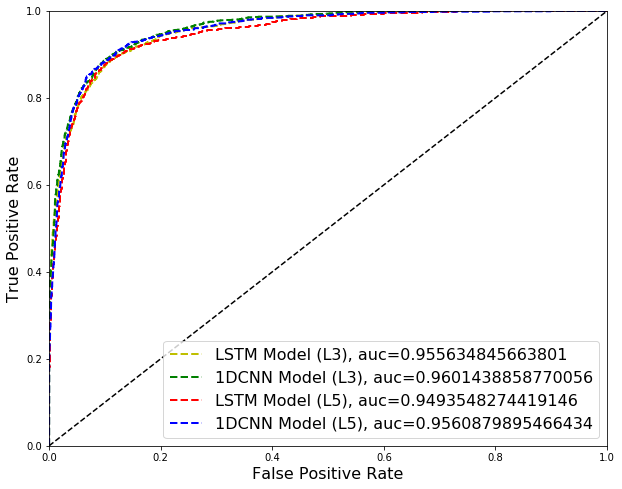

In [186]:
# Lets Plot all ROC Curves Together

plt.figure(figsize=(10, 8))
plt.plot(L3_LSTM_fpr, L3_LSTM_tpr, "y--", linewidth=2, label="LSTM Model (L3), auc="+str(L3_LSTM_roc_auc))
plt.plot(L3_1DCNN_fpr, L3_1DCNN_tpr, "g--", linewidth=2, label="1DCNN Model (L3), auc="+str(L3_1DCNN_roc_auc))
plt.plot(L5_LSTM_fpr, L5_LSTM_tpr, "r--", linewidth=2, label="LSTM Model (L5), auc="+str(L5_LSTM_roc_auc))
plot_roc_curve(L5_1DCNN_fpr, L5_1DCNN_tpr,label="1DCNN Model (L5), auc="+str(L5_1DCNN_roc_auc) )
plt.legend(loc="lower right", fontsize=16)
plt.show()